In [1]:
# DL framework# DL fr 
import tensorflow as tf

from datetime import datetime

# common packages
import numpy as np
import os
import math
import cv2

# timing epochs
import time

# read image
from imageio import imread

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# not necessary, but will remove warning about corrupt EXIF data on images
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

# const
SEED = 42

# Helper to make the output consistent
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

    
# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Check TensorFlow version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


In [2]:
SQUARE_DIM  = 150
if SQUARE_DIM:
    IMG_WIDTH = SQUARE_DIM
    IMG_HEIGHT = SQUARE_DIM
    
CHANNELS = 3

In [3]:
# preprocessing
def prep_image(image, target_width=IMG_WIDTH, target_height=IMG_HEIGHT, centerCrop=True):
    
    if centerCrop:
        image_shape = tf.cast(tf.shape(image), tf.float32)
        height = image_shape[0]
        width = image_shape[1]
        image_ratio = width / height
        target_image_ratio = target_width / target_height
        
        # crop to square
        crop_vertically = image_ratio < target_image_ratio
        crop_width = tf.cond(crop_vertically,
                             lambda: width,
                             lambda: height * target_image_ratio)
        crop_height = tf.cond(crop_vertically,
                              lambda: width / target_image_ratio,
                              lambda: height)
        
        crop_width = tf.cast(crop_width, tf.float32)
        crop_height = tf.cast(crop_height, tf.float32)
        wStart = tf.cast((width - crop_width)/2, tf.int32)
        hStart = tf.cast((height - crop_height)/2,tf.int32)

        # center crop coordinates
        x0 = wStart
        y0 = hStart
        x1 = x0 + tf.cast(crop_width, tf.int32)
        y1 = y0 + tf.cast(crop_height, tf.int32)

        image = tf.image.crop_to_bounding_box(image, y0, x0, y1, x1)

    image_batch = tf.expand_dims(image, 0)
    image = tf.image.resize_bilinear(image_batch, [target_height, target_width])[0]

    return image

In [4]:
## set up inputs/
data_path = "/home/jackburdick/dev/github/YeahML/examples/cats_v_dogs/make_records/raw_cats_vs_dogs/PetImages"
dog_path = os.path.join(data_path,"Dog")
cat_path = os.path.join(data_path,"Cat")
dog_LABEL = 1
cat_LABEL = 0

In [5]:
path_list_and_label = []
for dir_path in [dog_path, cat_path]:
    for _, _, files in os.walk(dir_path):
        for filename in files:
            if filename.endswith(".jpg"):
                if dir_path == dog_path:
                    path_list_and_label.append((os.path.join(dir_path, filename), dog_LABEL))
                elif dir_path == cat_path:
                    path_list_and_label.append((os.path.join(dir_path, filename), cat_LABEL))
                else:
                    print("not a cat or dog?")
            else:
                print("skipping file : {}".format(filename))
total_instances_n = len(path_list_and_label)
print(total_instances_n)

skipping file : Thumbs.db
skipping file : Thumbs.db
25000


In [6]:
X_in = np.zeros((total_instances_n, IMG_WIDTH, IMG_HEIGHT, 3), dtype='float32')
y_in = np.zeros((total_instances_n))
l_in = ([""] * total_instances_n)
print("img_shape: ", X_in[0].shape)
print("label_shape: ", y_in[0].shape)
#print(l_in)

img_shape:  (150, 150, 3)
label_shape:  ()


In [7]:
input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prep_image_op = prep_image(input_image)

index = 0
with tf.Session() as sess:
    for i, (f,label) in enumerate(path_list_and_label):
        try:
            img = imread(os.path.join(data_path, f))
            prepared_image = prep_image_op.eval(feed_dict={input_image: img})
            X_in[index] = prepared_image
            y_in[index] = label
        except:
            # color
            if len(img.shape) >= 3:
                if img.shape[2] == 4:
                    #print("shape of {} is {}, defaulting to first 3 channels".format(f, img.shape[2]))
                    prepared_image = prep_image_op.eval(feed_dict={input_image: img[:,:,:3]})
                    X_in[index] = prepared_image
                    y_in[index] = label
                elif img.shape[2] == 3:
                    prepared_image = prep_image_op.eval(feed_dict={input_image: img})
                    X_in[index] = prepared_image
                    y_in[index] = label
                else:
                    print("Weird shape for image {} = {}".format(f, img.shape))
                    break
            # grayscale
            else:
                # convert to color
                print("converting {} to color".format(f.split("/")[-2:]))
                backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
                prepared_image = prep_image_op.eval(feed_dict={input_image: backtorgb})
                X_in[index] = prepared_image
                y_in[index] = label
                pass
        
        l_in[index] = "{}_{}".format(f.split("/")[-2], f.split("/")[-1])
        index += 1
        if index % 250 == 0:
            print(index)

250
500
750
1000
1250
1500
converting ['Dog', '3823.jpg'] to color
1750
2000
2250
2500
2750
3000
3250
3500
3750
converting ['Dog', '1773.jpg'] to color
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
converting ['Dog', '1308.jpg'] to color
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500
14750
15000
15250
15500
converting ['Cat', '2939.jpg'] to color
15750
16000
16250
16500
16750
17000
17250
17500
17750
18000
18250
18500
18750
19000
19250
19500
converting ['Cat', '5686.jpg'] to color
19750
20000
20250
converting ['Cat', '7276.jpg'] to color
20500
20750
21000
21250
21500
21750
22000
converting ['Cat', '8470.jpg'] to color
22250
22500
22750
23000
23250
23500
23750
24000
24250
24500
24750
25000


In [9]:
# initial shuffle
from sklearn.utils import shuffle
X_in, y_in, l_in = shuffle(X_in, y_in, l_in, random_state=42)

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [11]:
l_in = np.asarray(l_in)

In [12]:
for train_index, test_index in split.split(X_in, y_in):
    train_set_x = X_in[train_index]
    strat_test_set_x = X_in[test_index]
    train_set_y = y_in[train_index]
    strat_test_set_y = y_in[test_index]
    train_set_l = l_in[train_index]
    strat_test_set_l = l_in[test_index]

In [13]:
print(len(strat_test_set_x))
print(len(strat_test_set_y))
print(len(strat_test_set_l))

5000
5000
5000


1.0
Dog_8959.jpg


(-0.5, 149.5, 149.5, -0.5)

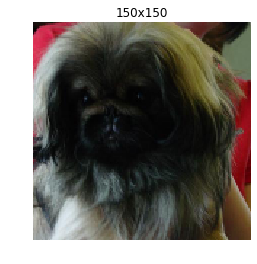

In [14]:
image = strat_test_set_x[15]
label = strat_test_set_y[15]
l = strat_test_set_l[15]
print(label)
print(l)
plt.imshow(image.astype(np.uint8),interpolation="nearest")
plt.title("{}x{}".format(image.shape[1], image.shape[0]))
plt.axis("off")

In [15]:
for train_index, val_index in split.split(train_set_x, train_set_y):
    strat_train_set_x = train_set_x[train_index]
    strat_val_set_x = train_set_x[val_index]
    strat_train_set_y = train_set_y[train_index]
    strat_val_set_y = train_set_y[val_index]
    strat_train_set_l = train_set_l[train_index]
    strat_val_set_l = train_set_l[val_index]

In [16]:
print("train:", "X", strat_train_set_x.shape[0], "y", strat_train_set_y.shape[0], "l", strat_train_set_l.shape[0])
print("val:", "X", strat_val_set_x.shape[0], "y", strat_val_set_y.shape[0], "l", strat_val_set_l.shape[0])
print("test:", "X", strat_test_set_x.shape[0], "y", strat_test_set_y.shape[0], "l", strat_test_set_l.shape[0])

train: X 16000 y 16000 l 16000
val: X 4000 y 4000 l 4000
test: X 5000 y 5000 l 5000


In [17]:
print("train-----")
y1 = 0
y0 = 0
for y in strat_train_set_y:
    if y == 1:
        y1 += 1
    elif y == 0:
        y0 += 1
print(y1)
print(y0)

print("val-----")
y1 = 0
y0 = 0
for y in strat_val_set_y:
    if y == 1:
        y1 += 1
    elif y == 0:
        y0 += 1
print(y1)
print(y0)

print("test-----")
y1 = 0
y0 = 0
for y in strat_test_set_y:
    if y == 1:
        y1 += 1
    elif y == 0:
        y0 += 1
print(y1)
print(y0)

train-----
8000
8000
val-----
2000
2000
test-----
2500
2500


1.0
Dog_9798.jpg


(-0.5, 149.5, 149.5, -0.5)

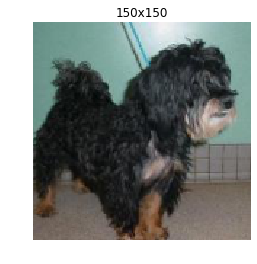

In [18]:
num = 3
image = strat_train_set_x[num]
label = strat_train_set_y[num]
idv = strat_train_set_l[num]
print(label)
print(idv)
plt.imshow(image.astype(np.uint8),interpolation="nearest")
plt.title("{}x{}".format(image.shape[1], image.shape[0]))
plt.axis("off")

In [19]:
def maybe_create_dir(dir_path: str) -> None:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("{} created".format(dir_path))
    else:
        print("{} already exists".format(dir_path))
        
maybe_create_dir('../data/numpy/' + str(SQUARE_DIM))

../data/numpy/150 created


In [20]:
np.save('../data/numpy/' + str(SQUARE_DIM) + '/X_train.npy', strat_train_set_x)
np.save('../data/numpy/' + str(SQUARE_DIM) + '/y_train.npy', strat_train_set_y)
np.save('../data/numpy/' + str(SQUARE_DIM) + '/l_train.npy', strat_train_set_l)

In [21]:
np.save('../data/numpy/' + str(SQUARE_DIM) + '/X_val.npy', strat_val_set_x)
np.save('../data/numpy/' + str(SQUARE_DIM) + '/y_val.npy', strat_val_set_y)
np.save('../data/numpy/' + str(SQUARE_DIM) + '/l_val.npy', strat_val_set_l)

In [22]:
np.save('../data/numpy/' + str(SQUARE_DIM) + '/X_test.npy', strat_test_set_x)
np.save('../data/numpy/' + str(SQUARE_DIM) + '/y_test.npy', strat_test_set_y)
np.save('../data/numpy/' + str(SQUARE_DIM) + '/l_test.npy', strat_test_set_l)